# ECOSTRESS data wrangling

From [AppEEARS](https://lpdaacsvc.cr.usgs.gov/appeears), I've downloaded a whole collection of geotiffs for ECOSTRESS LST for a bounding box around Clear Lake. 

Next I'd like to open all those images and see if I can stack them together into a big NetCDF file or something. Then we'd have a big LST data cube to work with!

In [1]:
import os
import xarray as xr
import rioxarray as rioxr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, mapping

import matplotlib.pyplot as plt
%matplotlib inline

Set the path to the top level directory where all our ECOSTRESS images are, their file extension, and product name.

In [2]:
eco_tiff_path = '/home/jovyan/data/ECOSTRESS/'
ext = '.tif'
product = 'SDS_LST_doy'

Get a list of all our ECOSTRESS LST files

In [3]:
# get list of all tif files
file_list = []
for root, dirs, files in os.walk(eco_tiff_path):
    for file in files:
        if file.endswith(ext):
            if product in file:
                 file_list.append( os.path.join(root, file) ) 

Open each file, and build up a data cube of ECOSTRESS LST over time

In [4]:
for i, file in enumerate(file_list):
    
    # open this file
    this_eco_lst = xr.open_rasterio(file_list[10])
    
    # get the timestring from the filename
    file_datestring = file.split('/')[-1].split('_')[-2][3:]
    
    # convert to pandas timestamp
    file_timestamp = pd.to_datetime(file_datestring, format='%Y%j%H%M%S')
    
    # unpack all our values
    lst = this_eco_lst.values
    lon = this_eco_lst.x.values
    lat = this_eco_lst.y.values
    time = np.array([file_timestamp])
    metadata = this_eco_lst.attrs
    
    # repackage into a DataArray
    eco_lst_da = xr.DataArray(lst, 
                              coords=[time, lat, lon], 
                              dims=['time', 'y', 'x'],  
                              name='lst', 
                              attrs=metadata)
    
    # if this is our first DataArray, make our dataset
    if i == 0:
        eco_lst = eco_lst_da
    else:
        eco_lst = xr.merge([eco_lst, eco_lst_da])

# add the attributes at the dataset level
eco_lst.attrs = metadata

Open our Clear Lake shapefile

In [5]:
clearlake = gpd.read_file('zip://../data/Clear_Lake_Res.zip')
clearlake.head()

,DFGWATERID,TYPE,NAME,GNIS_NAME,GNIS_ID,COUNTY,QUAD_NAME,QUAD_CODE,LAT_NAD83,LON_NAD83,UTM_ZONE,UTM_N_N83,UTM_E_N83,MTR,elev_ft,sfc_acres,Shape_Leng,Shape_Area,geometry
0,8177,perennial,Clear Lake Reservoir,Clear Lake Reservoir,221199.0,Modoc,DOUBLE HEAD MTN.,41121G2,41.865752,-121.144879,10.0,4.636535e+06,653962.164441,M47N 07E,4484,25012.128035,110372.801128,1.012209e+08,"MULTIPOLYGON Z (((-89566.185 434787.792 0.000,..."


Are we in the same crs?

In [6]:
print('ECOSTRESS CRS: {}'.format(eco_lst.crs))
print('Shapefile CRS: {}'.format(clearlake.crs))

ECOSTRESS CRS: +init=epsg:4326
Shapefile CRS: epsg:3310


No, so let's fix it

In [7]:
clearlake = clearlake.to_crs(eco_lst.crs)

/home/jovyan/data/conda-envs/firewaterenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [8]:
print('ECOSTRESS CRS: {}'.format(eco_lst.crs))
print('Shapefile CRS: {}'.format(clearlake.crs))

ECOSTRESS CRS: +init=epsg:4326
Shapefile CRS: +init=epsg:4326 +type=crs


Scale the temperature values and convert LST from K to degrees C

In [9]:
eco_lst['lst'] = eco_lst.lst * float(eco_lst.attrs['scale_factor']) - 273.15

In [15]:
# add the attributes here too
eco_lst.lst.attrs = metadata

Plot our ECOSTRESS image and Clear Lake Shapefile

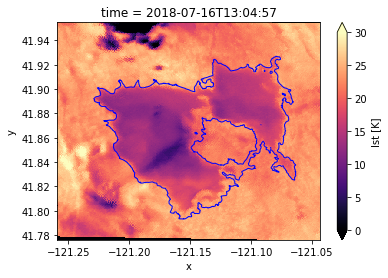

In [16]:
fig, ax = plt.subplots()

eco_lst.isel(time=0).lst.plot(x='x', y='y', ax=ax, vmin=0, vmax=30, cmap='magma')

clearlake.plot(ax=ax, edgecolor='blue', facecolor='none');

ax.set_aspect(1)

Mask using the Clear Lake shapefile

In [17]:
clearlake_lst = eco_lst.rio.clip(clearlake.geometry.apply(mapping))

# switch our zero values to nan values
clearlake_lst = clearlake_lst.where(clearlake_lst > 0)

/home/jovyan/data/conda-envs/firewaterenv/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Export to a NetCDF file

In [19]:
clearlake_lst.to_netcdf('clearlake_eco_lst.nc')

---
Plot the clipped ECOSTRESS image and histogram with summary statistics and compute some zonal statistics

In [29]:
for i in range(clearlake_lst.time.shape):
    print(i)

TypeError: 'tuple' object cannot be interpreted as an integer

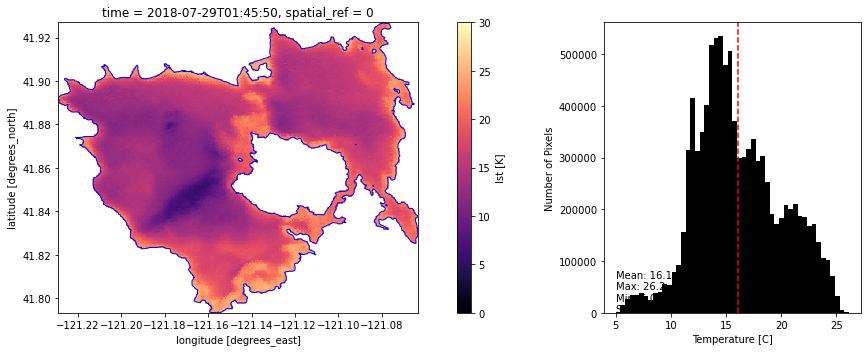

In [26]:


# Compute zonal statistics
# Remove NaN pixel values
values = clearlake_lst.lst.isel(time=i).values.flatten()
values = values[~np.isnan(values)]

clearlake_lst_mean = values.mean()
clearlake_lst_max = values.max()
clearlake_lst_min = values.min()
clearlake_lst_std = values.std()

# Print zonal statistics
summary_stats = 'Mean: {}\nMax: {}\nMin: {}\nStd: {}'.format(np.round(clearlake_lst_mean,1),
                                                             np.round(clearlake_lst_max,1),
                                                             np.round(clearlake_lst_min,1),
                                                             np.round(clearlake_lst_std,1))

print(summary_stats)



# Plot figures
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5), gridspec_kw={'width_ratios': [3, 1]})

# image
clearlake_lst.lst.isel(time=i).plot(x='x', y='y', ax=ax1, vmin=0, vmax=30, cmap='magma')
clearlake.plot(ax=ax1, edgecolor='blue', facecolor='none');
ax1.set_aspect(1)


## histogram
ax2.hist(values, bins=50, facecolor='k');
ax2.axvline(x=clearlake_lst_mean, c='r', linestyle='--')
ax2.text(5,600,summary_stats)
ax2.set_ylabel('Number of Pixels')
ax2.set_xlabel('Temperature [C]')

plt.tight_layout()